In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import read_dot, graphviz_layout

import utilities.stats as stats
import utilities.graphs as graphs
import utilities.sqlite_helper as helper

In [4]:
# Needs to be done when there are changes in these files ...
import importlib
importlib.reload(helper)
importlib.reload(stats)
importlib.reload(graphs)
print("Updates imports")

Updates imports


#### [] Remove failed benchmarks

#### Helpers

In [5]:
def get_name_from_dot(path):
    # Remove last dot, remove last 3 "_" which are hardcoded
    return path.split("/")[-1].rsplit(".", 1)[0].rsplit("_", 3)[0]

def get_name_from_db_bench(name):
    return name.replace("/", "-")

In [6]:
def change(rl: float, ru: float):
    if ru < 1:
        return (1-ru) * 100
    elif rl > 1:
        return (rl-1) * 100
    else:
        return 0

In [8]:
# Hierachical Bootstrap
def boostrap_ratio_mean_laaber(benchmark: dict, num_iterations: int=10000):
    bootstrap_mean = []
    for _ in range(num_iterations):
        samples = []
        trials = list(benchmark.keys())
        for _ in trials:
            # Pick random trial
            random_trial = np.random.choice(trials, replace=True)
            iterations = list(benchmark[random_trial])
            
            for _ in iterations:
                # Pick random iteration
                random_iteration_idx = np.random.choice(len(iterations), replace=True)
                ns = iterations[random_iteration_idx][2]
                samples.append(ns)

        bootstrap_mean.append(np.mean(samples))  
    return bootstrap_mean          


# Loading Data for instability

In [9]:
db_path_tags = "/Users/christopher/Uni/MasterThesis/experiment6_goquery/goquery3tags.db"

In [10]:
measurements = helper.get_all_measurements(db_path_tags, start_form_count=1)

# group by tag/version
grouped_by_tag = helper.group_measurements_by_property(measurements, -2)

# group by benchmark name
for tag in grouped_by_tag.keys():
    grouped_by_tag[tag] = helper.group_measurements_by_property(grouped_by_tag[tag], -3)

In [11]:
total_measurements = len(grouped_by_tag['v1.7.1'])

In [12]:
print(f"Avialable tags: {grouped_by_tag.keys()}")
print(f"Total measurements in first tag: {total_measurements}")

Avialable tags: dict_keys(['v1.8.1', 'v1.7.1', 'v1.8.0'])
Total measurements in first tag: 86


v1.7.1 BenchmarkAddNodes 0.14007300585699942


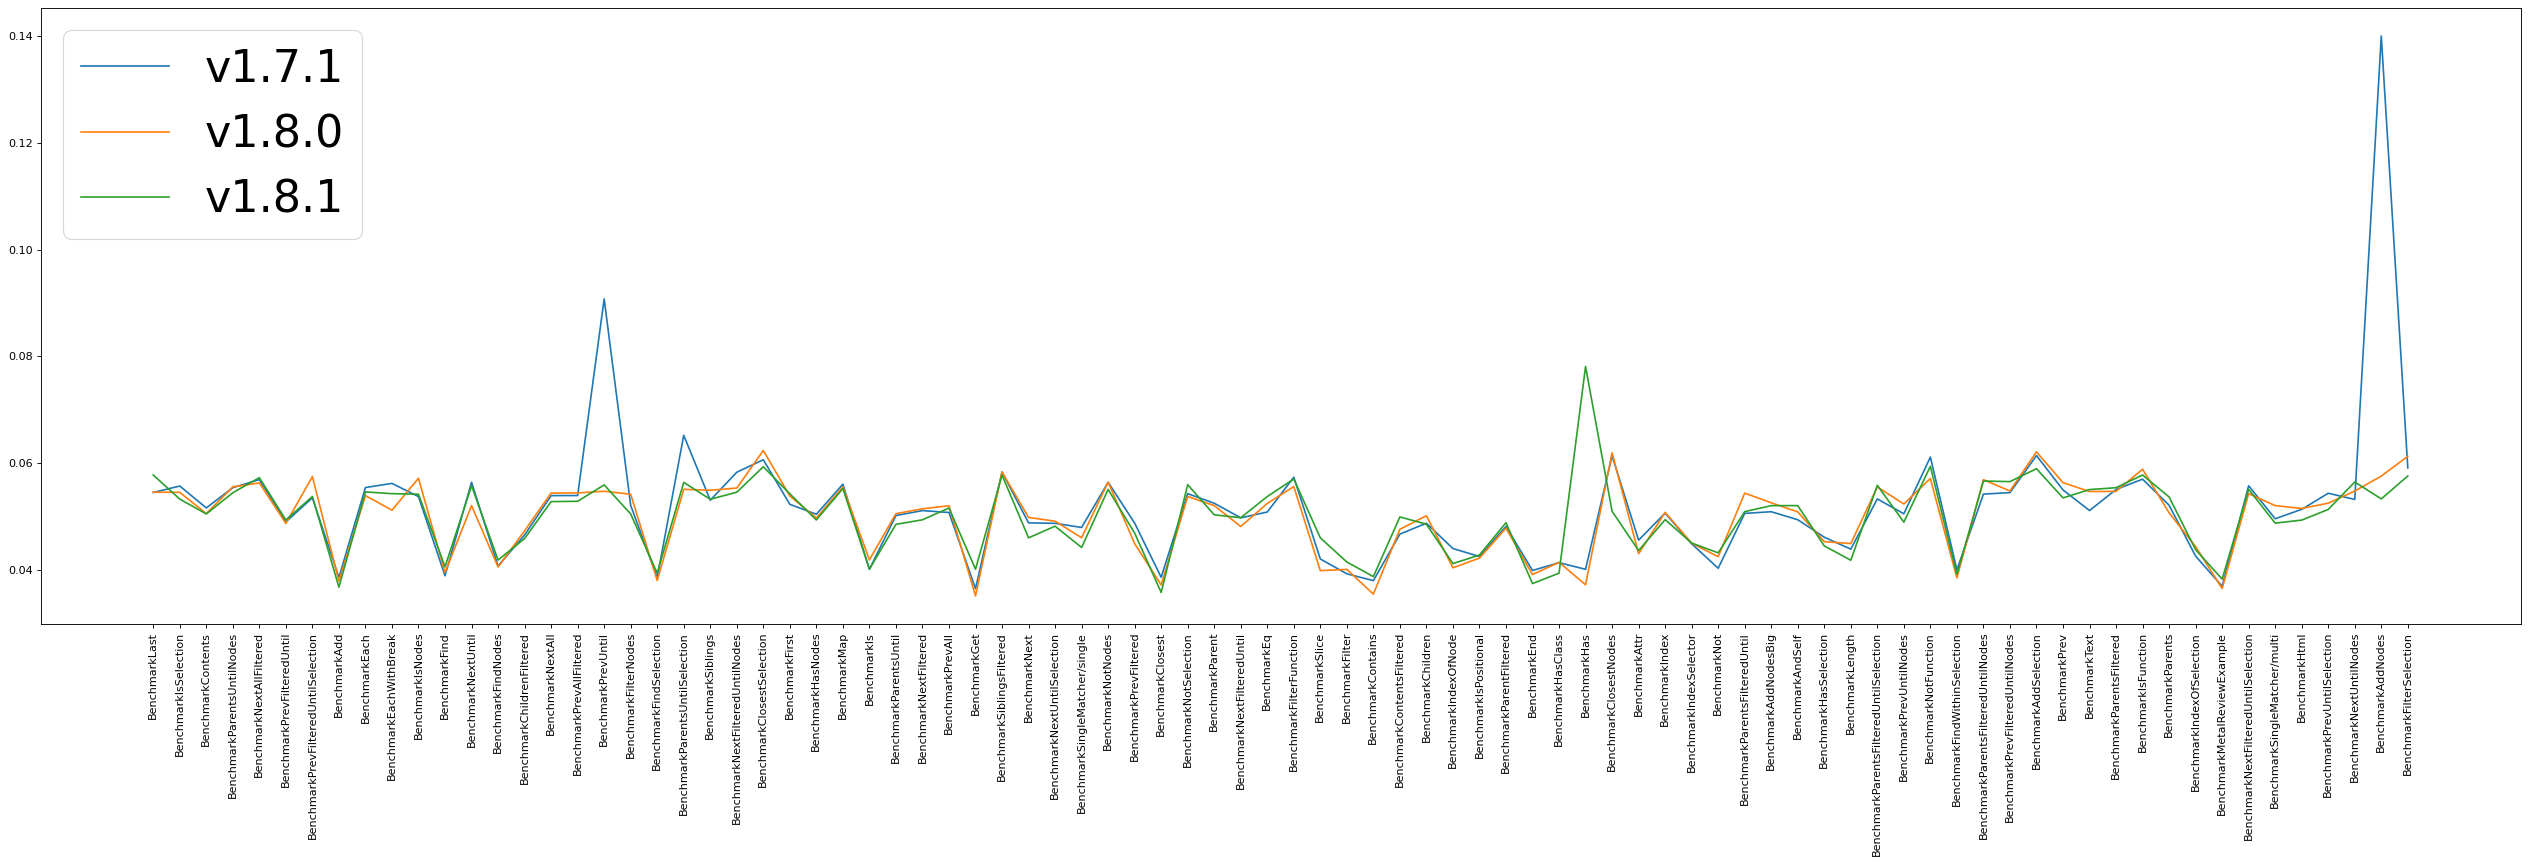

In [13]:
unstable_benchmarks = []
stability_measures = {}

plt.figure(figsize=(40, 10), dpi=80)

labels=list(next(iter(grouped_by_tag.values())).keys())
plt.xticks([x for x in range(len(labels))], labels, rotation='vertical')

tags = list(grouped_by_tag.keys())
tags.sort()

for tag in tags:
    cv = []
    spread = []
    for bench in grouped_by_tag[tag].keys():
        x = []
        measurments = grouped_by_tag[tag][bench]
        for entry in measurments:
            x.append(entry[2])
        current_cv = stats.cv(x)
        cv.append(current_cv)
        try:
            stability_measures[get_name_from_db_bench(bench)].append(current_cv)
        except KeyError:
            stability_measures[get_name_from_db_bench(bench)] = [current_cv]

        if (current_cv) > 0.1 and tag == "v1.7.1":
            print(f"{tag} {bench} {current_cv}")
            unstable_benchmarks.append(get_name_from_db_bench(bench))
        spread.append(stats.max_spread(x))

    plt.plot(cv, label=tag)
plt.legend(fontsize="40")
plt.show()

# Calculate Performance Changes

In [14]:
# group by trial
for tag in grouped_by_tag.keys():
    for bench in grouped_by_tag[tag].keys():
        grouped_by_tag[tag][bench] = helper.group_measurements_by_property(grouped_by_tag[tag][bench], -5)

In [15]:
# Increase to 10000
changes = []
for bench in list(grouped_by_tag['v1.7.1'].keys()):
    b_mean_old = boostrap_ratio_mean_laaber(grouped_by_tag['v1.7.1'][bench], 1000)
    b_mean_new = boostrap_ratio_mean_laaber(grouped_by_tag['v1.8.0'][bench], 1000)

    R_B = []
    for i in range(len(b_mean_old)):
        R_B.append(b_mean_new[i] / b_mean_old[i])


    cl = 0.99
    lower_percentile = (1 - cl) / 2
    upper_percentile = 1 - lower_percentile
    lower_bound = np.percentile(R_B, lower_percentile * 100)
    upper_bound = np.percentile(R_B, upper_percentile * 100)
    performance_change = change(lower_bound, upper_bound)
    changes.append(performance_change)

In [19]:
grouped_by_tag['v1.7.1'][bench][1]

[(3224,
  28465,
  43997.0,
  1,
  5,
  3,
  3,
  1,
  1,
  1,
  52,
  'BenchmarkFilterSelection',
  'v1.7.1',
  1),
 (3225,
  27880,
  41720.0,
  1,
  5,
  3,
  3,
  1,
  1,
  1,
  52,
  'BenchmarkFilterSelection',
  'v1.7.1',
  2),
 (3479,
  24698,
  49267.0,
  1,
  5,
  3,
  3,
  1,
  1,
  1,
  56,
  'BenchmarkFilterSelection',
  'v1.7.1',
  1),
 (3480,
  24505,
  48923.0,
  1,
  5,
  3,
  3,
  1,
  1,
  1,
  56,
  'BenchmarkFilterSelection',
  'v1.7.1',
  2),
 (3860,
  25152,
  48103.0,
  1,
  5,
  3,
  3,
  1,
  2,
  1,
  62,
  'BenchmarkFilterSelection',
  'v1.7.1',
  1),
 (3861,
  25030,
  48538.0,
  1,
  5,
  3,
  3,
  1,
  2,
  1,
  62,
  'BenchmarkFilterSelection',
  'v1.7.1',
  2),
 (4928,
  25719,
  46427.0,
  1,
  5,
  3,
  3,
  1,
  1,
  1,
  79,
  'BenchmarkFilterSelection',
  'v1.7.1',
  1),
 (4929,
  25839,
  46156.0,
  1,
  5,
  3,
  3,
  1,
  1,
  1,
  79,
  'BenchmarkFilterSelection',
  'v1.7.1',
  2),
 (5294,
  25946,
  46641.0,
  1,
  5,
  3,
  3,
  1,
  2,
  1,
 

In [226]:
perf_dict = {}
for idx, x in enumerate(changes):
    if x <= 0:
        continue
    name = list(grouped_by_tag['v1.7.1'].keys())[idx]
    name = get_name_from_db_bench(name)
    perf_dict[name] = x
print(f"Found the following performance changes: {perf_dict}")
print(len(perf_dict.keys()))

Found the following performance changes: {'BenchmarkGet': 18.440322947801956, 'BenchmarkSlice': 12.746485428348088, 'BenchmarkContains': 3.5452108164123697, 'BenchmarkIndexOfNode': 1.2841264445521694, 'BenchmarkIsPositional': 0.8633595023691876, 'BenchmarkEnd': 96.5448190374181, 'BenchmarkHas': 0.3353332296643474, 'BenchmarkAttr': 6.675577502806762, 'BenchmarkIndexOfSelection': 22.926414121935867, 'BenchmarkMetalReviewExample': 0.9321798902086509}
10


# Load Graph Data

In [227]:
graph_paths0 = "/Users/christopher/Uni/MasterThesis/experiment6_goquery/backup-mt-1-instance-0/"
graph_paths1 = "/Users/christopher/Uni/MasterThesis/experiment6_goquery/backup-mt-1-instance-1/"

In [228]:
dot_files = []
for graph_paths in [graph_paths0, graph_paths1]:
    # Convert files to dot files for further analysis

    # Clear existing dot files
    for existingDotFile in glob.glob(graph_paths + "*.dot"):
        os.remove(existingDotFile)

    if len(glob.glob(graph_paths + "*.dot")) == 0:
        files = glob.glob(graph_paths + "*")
        for file in files:
            
            if file.endswith(".dot"):
                continue
            
            name = file.split(".out")[0]
            command = f"go tool pprof -nodecount=3000 --nodefraction=0.0 --edgefraction=0.0 -dot {name}.out > {name}.dot"
            # command = f"go tool pprof -hide='runtime.*|testing.*' -nodecount=10000 --nodefraction=0.0 --edgefraction=0.0 -dot '{name}.out' > '{name}.dot'"
            stream = os.popen(command)
            output = stream.read()
            

    dot_files.extend(glob.glob(graph_paths + "*.dot"))

/Users/christopher/Uni/MasterThesis/experiment6_goquery/backup-mt-1-instance-0/07-03-2023_backup-mt-1-instance-0-log.txt.out: open /Users/christopher/Uni/MasterThesis/experiment6_goquery/backup-mt-1-instance-0/07-03-2023_backup-mt-1-instance-0-log.txt.out: no such file or directory
failed to fetch any source profiles
/Users/christopher/Uni/MasterThesis/experiment6_goquery/backup-mt-1-instance-0/07-02-2023_backup-mt-1-instance-0-log.txt.out: open /Users/christopher/Uni/MasterThesis/experiment6_goquery/backup-mt-1-instance-0/07-02-2023_backup-mt-1-instance-0-log.txt.out: no such file or directory
failed to fetch any source profiles
/Users/christopher/Uni/MasterThesis/experiment6_goquery/backup-mt-1-instance-0/07-01-2023_backup-mt-1-instance-0-log.txt.out: open /Users/christopher/Uni/MasterThesis/experiment6_goquery/backup-mt-1-instance-0/07-01-2023_backup-mt-1-instance-0-log.txt.out: no such file or directory
failed to fetch any source profiles
/Users/christopher/Uni/MasterThesis/experim

In [229]:
"""Load and convert all graphs, and generate a unique node mapping."""
count_bad_input = 0
ordered_graphs = {}
none_perf_benchs = []
removed_node_name = set()
for dot_file in dot_files:
    name = get_name_from_dot(dot_file)

    if "BenchmarkSize" in name or "BenchmarkMemory" in name:
        none_perf_benchs.append(name)
        continue
    
    try:
        curr_graph = read_dot(dot_file)
        curr_graph = graphs.convertWeigthsToFloat(curr_graph)
    except ValueError: 
        count_bad_input += 1
        print(dot_file.split("/")[-1])
        continue
    
    # Check if one of the nodes includes 'runActualBenchmark, if yes create a subgraph starting at that node
    for node in curr_graph.nodes(data=True):
        if 'ActualBenchmark' in node[1]['label']:
            print(f"Found {node[1]['label']}")
        break

    # Removing starting nodes like file, type etc.
    try:
        name_first_node = list(curr_graph.nodes(data=True))[0][0]
        if name_first_node != "N1":
            removed_node_name.add(name_first_node)
            curr_graph.remove_node(name_first_node)
    except Exception as e:
        print(e)

    # Add all graphs from the same benchmark together and later form the union
    try: 
        ordered_graphs[name].append(curr_graph)
    except KeyError:
       ordered_graphs[name] = []
       ordered_graphs[name].append(curr_graph)


print(f"Bad input: {count_bad_input}")
print(f"None perf benchmarks: {none_perf_benchs}")
print(f"Removed node names: {removed_node_name}")

07-02-2023_backup-mt-1-instance-0-log.txt.dot
07-03-2023_backup-mt-1-instance-0-log.txt.dot
07-01-2023_backup-mt-1-instance-0-log.txt.dot
07-01-2023_backup-mt-1-instance-1-log.txt.dot
07-03-2023_backup-mt-1-instance-1-log.txt.dot
07-02-2023_backup-mt-1-instance-1-log.txt.dot
Bad input: 6
None perf benchmarks: []
Removed node names: {'File: goquery.test'}


In [230]:
all_graphs = [val for sublist in ordered_graphs.values() for val in sublist]
nameMappingFull = graphs.generateUniqueNodeMapping(all_graphs)

In [231]:
final_graphs = []
for keys in ordered_graphs.keys():
    
    if len(ordered_graphs[keys]) != 2:
        print(keys, len(ordered_graphs[keys]))

    union_graphs = []
    for graph in ordered_graphs[keys]:
        mapping = graphs.getNodeNameMapping(graph)
        
        nodeMapping = {}
        # get node name by value
        for key in mapping:
            nodeMapping[key] = nameMappingFull[mapping[key]]

        union_graphs.append(nx.relabel_nodes(graph, nodeMapping))

    final_graphs.append(nx.compose_all(union_graphs))
print(f"Processed all graphs, amount of final graphs {len(final_graphs)}")

Processed all graphs, amount of final graphs 86


In [232]:
""" Generate full graph, position and labels."""
labeldict = {v: k for k, v in nameMappingFull.items()}
full_graph = nx.compose_all(final_graphs)
pos_full = graphviz_layout(full_graph, prog='dot')

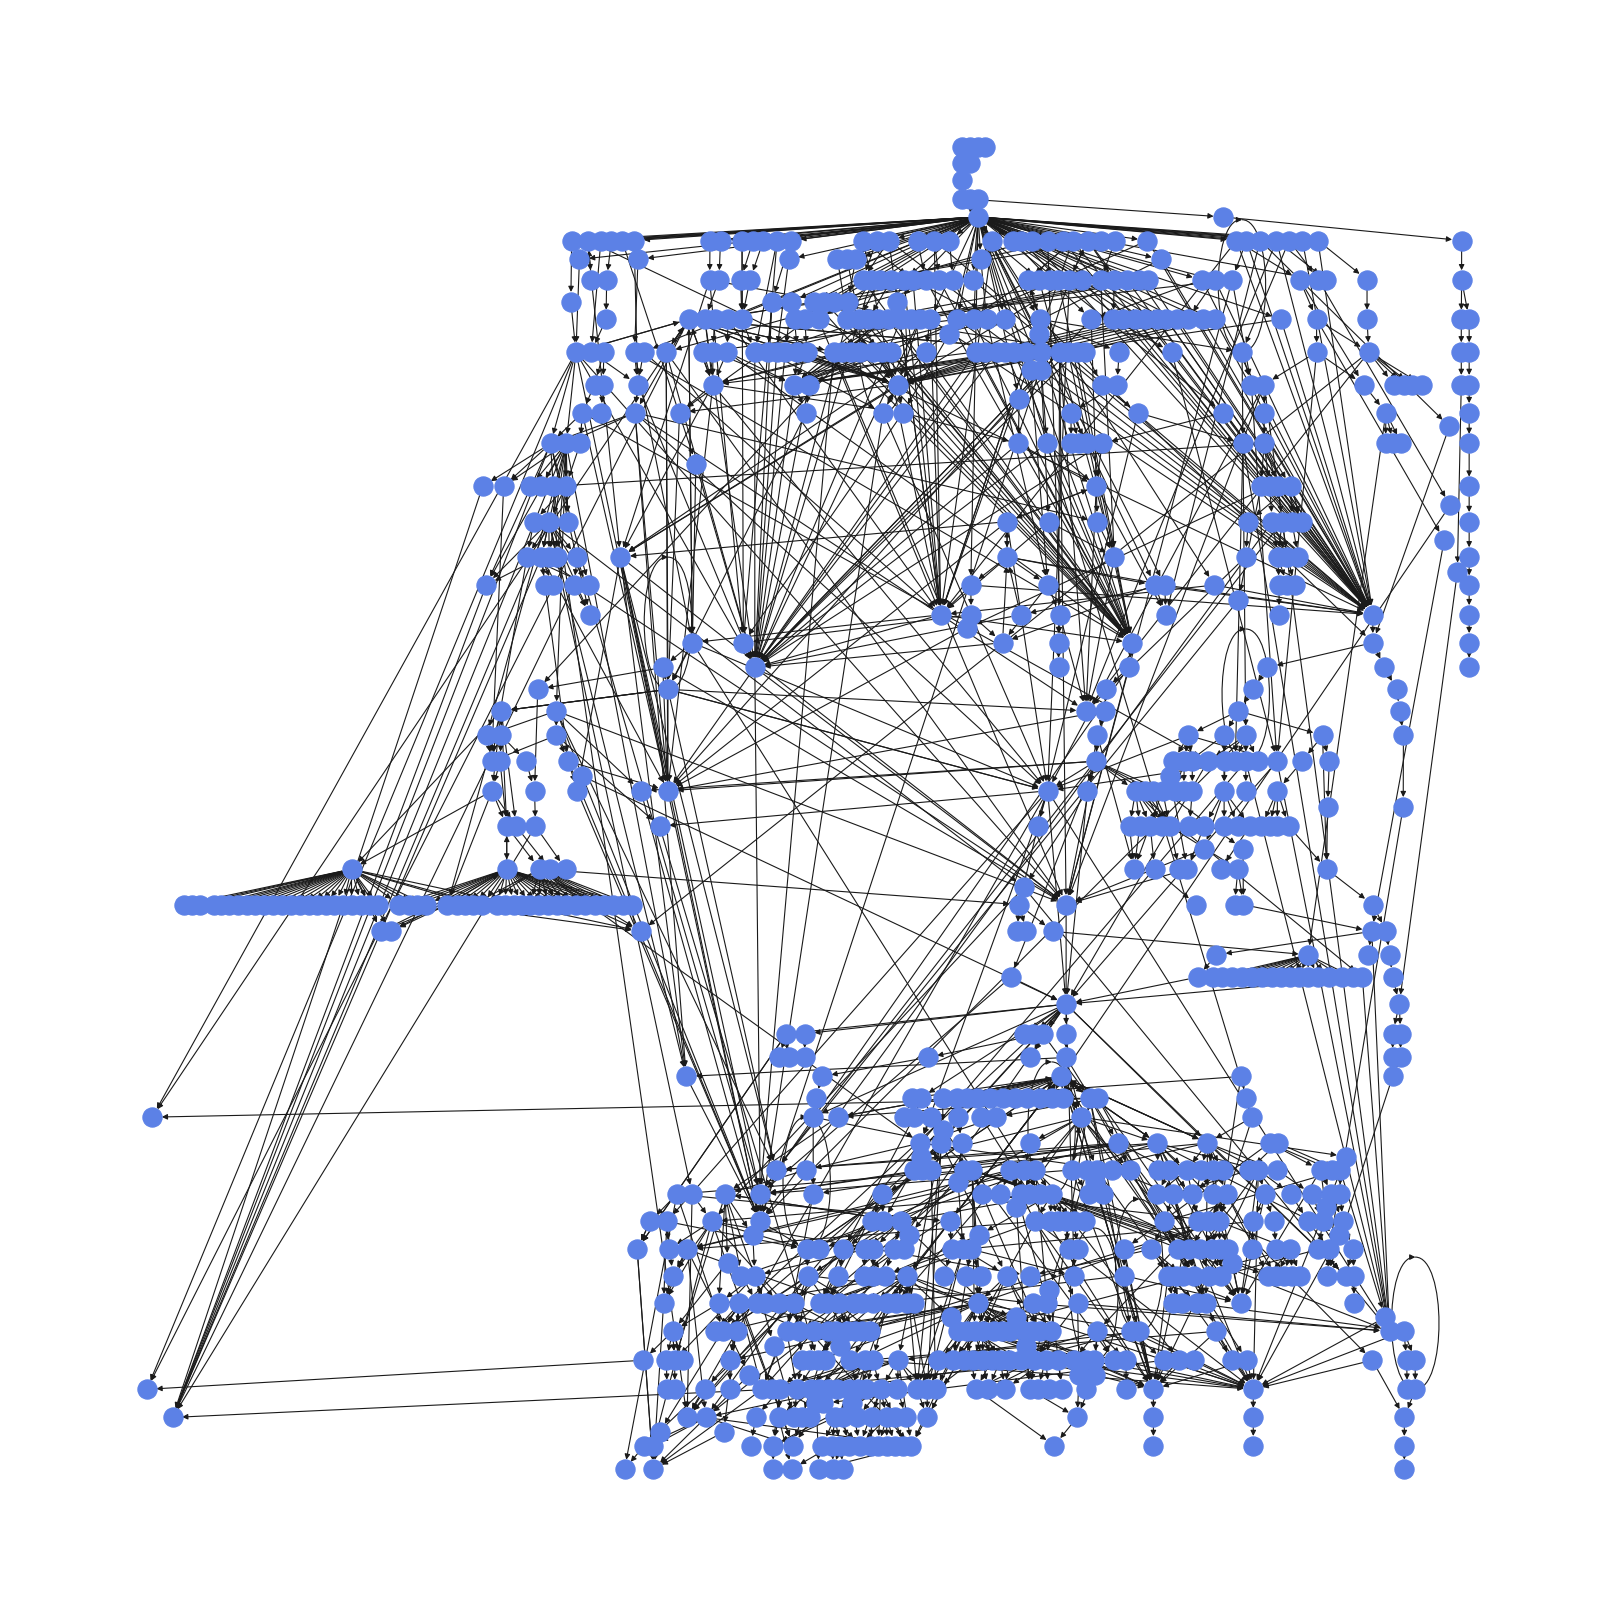

In [233]:
plt.figure(figsize=(20, 20), dpi=80)
nx.draw(full_graph, pos_full, arrows=True, node_color="#5c81e6")
plt.show()

#### Preprocessing

In [234]:
# Remove unstable nodes where dotfile name is same as db measurement
unstable_benchmarks_idx = []
for idx, graph in enumerate(final_graphs):
    if list(ordered_graphs.keys())[idx].rsplit("_", 1)[1] in unstable_benchmarks:
        print("Removing unstable benchmark", list(ordered_graphs.keys())[idx])
        unstable_benchmarks_idx.append(idx)

print(unstable_benchmarks_idx)

Removing unstable benchmark 07-03-2023_BenchmarkAddNodes
[5]


# Reduction Algorithm

Switched for more stable benchmark
Switched for more stable benchmark


Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more st

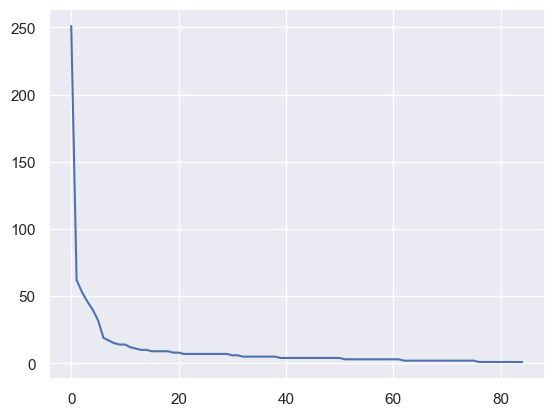

In [235]:
"""Take graphs with highest coverage and remove them from the remaining graphs."""
available_graphs = final_graphs.copy()
reduce_graphs_nodes = []
remaining_graph = full_graph.copy()
coverage_information = {}
iterations = 0
used_graph_idx = []

while len(remaining_graph.nodes()) > 1:
    
    # Find highest coverage within the unused benchmark graphs
    highest_coverage = (0, 0)
    
    for idx, benchmark_graph in enumerate(available_graphs):  

        if (idx in used_graph_idx) or (idx in unstable_benchmarks_idx): # or (idx in failed_benchs_idx):
            continue

        overlap_nodes = np.intersect1d(list(benchmark_graph.nodes()), list(remaining_graph.nodes()))
        overlap = len(overlap_nodes)

        if overlap == highest_coverage[1] and overlap > 0:
            name_curr = list(ordered_graphs.keys())[idx].split("_", 1)[1]
            name_highest = list(ordered_graphs.keys())[highest_coverage[0]].split("_", 1)[1]

            try:
                stability_curr = np.mean(stability_measures[name_curr])
                stability_high = np.mean(stability_measures[name_highest])
            except KeyError:
                print("Key error", name_curr, name_highest)
                continue
                        
            # print(f"Remaining: {len(remaining_graph.nodes())} - Overlap between {idx} and {highest_coverage[0]}: {overlap}, Stabilities: {stability_curr} {stability_high}")
            # Take the more stable benchmark

            if stability_curr < stability_high:
                print("Switched for more stable benchmark")
                highest_coverage = (idx, overlap)
            
        if overlap > highest_coverage[1]:
            highest_coverage = (idx, overlap)
        
        if iterations == 0:
            coverage_information[list(ordered_graphs.keys())[idx]] = overlap

    
    # if iterations % 20  == 0:
    #     plt.figure(figsize=(20, 20), dpi=80)
    #     color_map_full = ['blue' if node in remaining_graph.nodes()  else 'green' for node in full_graph.nodes()]
    #     nx.draw(full_graph, pos_full, with_labels=False, arrows=True, node_color=color_map_full)
    #     plt.show()

    if highest_coverage[1] == 0:
        print(f"Failed to find graph with overlap, Remaining: {len(remaining_graph.nodes())}")
        break
    
    reduce_graphs_nodes.append(highest_coverage)
    
    # remove graph from unused graphs and nodes from remaining graph
    used_graph = available_graphs[highest_coverage[0]].copy()
    used_graph_idx.append(highest_coverage[0])
    remaining_graph.remove_nodes_from(used_graph.nodes())
    iterations += 1

plt.plot([x[1] for x in reduce_graphs_nodes])
plt.show()

# Edge Coverage

Failed to find graph with overlap, Remaining: 3


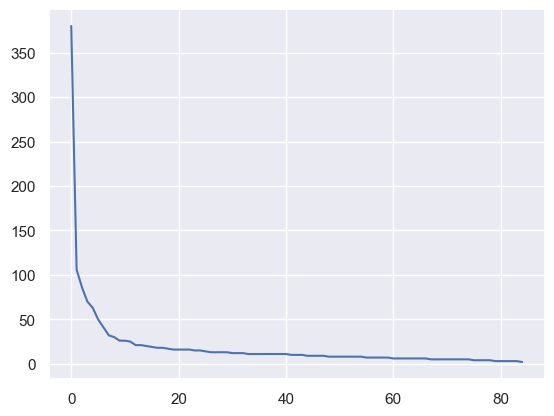

In [236]:
"""Take graphs with highest coverage and remove them from the remaining graphs."""
available_graphs = final_graphs.copy()
reduce_graphs_edges = []
remaining_graph = full_graph.copy()
coverage_information_edges = {}
iterations = 0
used_graph_idx_edges = []

while len(remaining_graph.nodes()) > 1:
    
    # Find highest coverage within the unused benchmark graphs
    highest_coverage = (0, 0)
    
    for idx, benchmark_graph in enumerate(available_graphs):  

        if (idx in used_graph_idx_edges) or (idx in unstable_benchmarks_idx): # or (idx in failed_benchs_idx):
            continue

        # Check edge overlap
        overlap_edges = set(benchmark_graph.edges()) & set(remaining_graph.edges())
        overlap = len(overlap_edges)
        
        if overlap == highest_coverage[1] and overlap > 0:
            name_curr = list(ordered_graphs.keys())[idx].split("_", 1)[1]
            name_highest = list(ordered_graphs.keys())[highest_coverage[0]].split("_", 1)[1]

            try:
                stability_curr = np.mean(stability_measures[name_curr])
                stability_high = np.mean(stability_measures[name_highest])
            except KeyError:
                print("Key error", name_curr, name_highest)
                continue
                        
            # print(f"Remaining: {len(remaining_graph.nodes())} - Overlap between {idx} and {highest_coverage[0]}: {overlap}, Stabilities: {stability_curr} {stability_high}")
            # Take the more stable benchmark

            if stability_curr < stability_high:
                # print("Switched for more stable benchmark")
                highest_coverage = (idx, overlap)
            
        if overlap > highest_coverage[1]:
            highest_coverage = (idx, overlap)
        
        if iterations == 0:
            coverage_information_edges[list(ordered_graphs.keys())[idx]] = overlap

    
    # if iterations % 20  == 0:
    #     plt.figure(figsize=(20, 20), dpi=80)
    #     color_map_full = ['blue' if node in remaining_graph.nodes()  else 'green' for node in full_graph.nodes()]
    #     nx.draw(full_graph, pos_full, with_labels=False, arrows=True, node_color=color_map_full)
    #     plt.show()

    if highest_coverage[1] == 0:
        print(f"Failed to find graph with overlap, Remaining: {len(remaining_graph.edges())}")
        break
    
    reduce_graphs_edges.append(highest_coverage)
    
    # remove graph from unused graphs and nodes from remaining graph
    used_graph = available_graphs[highest_coverage[0]].copy()
    used_graph_idx_edges.append(highest_coverage[0])

    # remove edges
    remaining_graph.remove_edges_from(used_graph.edges())
    iterations += 1

    if iterations % 10 == 0 and False:
        plt.figure(figsize=(10, 10), dpi=80)
        nx.draw(remaining_graph, pos_full, with_labels=False, arrows=True)
        plt.show()


plt.plot([x[1] for x in reduce_graphs_edges])
plt.show()

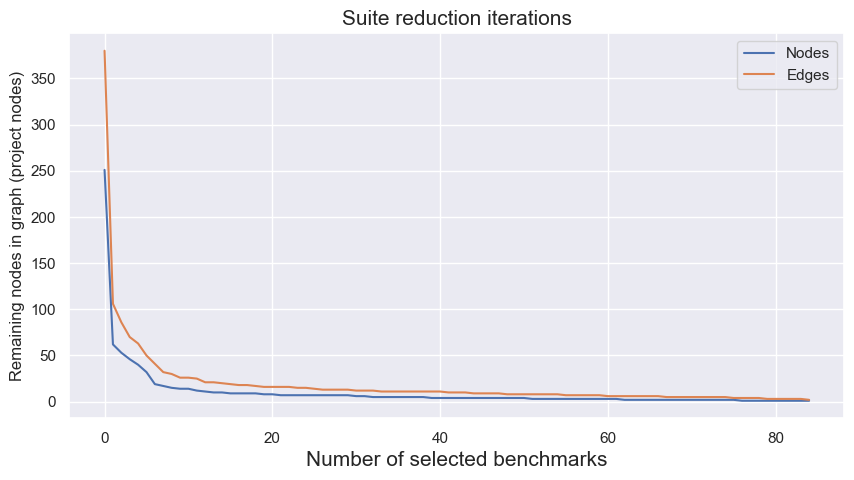

In [237]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title("Suite reduction iterations", fontsize=15)

plt.plot([x[1] for x in reduce_graphs_nodes], label="Nodes")
plt.plot([x[1] for x in reduce_graphs_edges], label="Edges")

plt.xlabel("Number of selected benchmarks", fontsize=15)
plt.ylabel("Remaining nodes in graph (project nodes)", fontsize=12)
# plt.savefig('graphics/goquery.png', dpi=300, bbox_inches='tight')
plt.legend()
plt.show()

In [241]:
print(f"Reduced with nodes from {len(final_graphs)} to {len(reduce_graphs_nodes)}")
print(f"Reduced with edges from {len(final_graphs)} to {len(reduce_graphs_edges)}")

Reduced with nodes from 86 to 85
Reduced with edges from 86 to 85


# Result Visualization

In [257]:
reduced_suite_nodes = [(x[0], list(ordered_graphs.keys())[x[0]].split('_', 1)[1]) for x in reduce_graphs_nodes]
reduced_suite_edges = [(x[0], list(ordered_graphs.keys())[x[0]].split('_', 1)[1]) for x in reduce_graphs_edges]
reduced_idx_nodes = [x[0] for x in reduce_graphs_nodes]
reduced_idx_edges = [x[0] for x in reduce_graphs_edges]

In [258]:
notFound = 0
failed_benchs_idx = []
stabilities_old = []
stabilities_new_nodes = []
stabilities_new_edges = []

for idx, x in enumerate(final_graphs):
    try:
        selected_bench = list(ordered_graphs.keys())[idx]
        name = selected_bench.split('_', 1)[1]
        stability = np.mean(stability_measures[name])
        stabilities_old.append(stability)
        if idx in reduced_idx_nodes:
            stabilities_new_nodes.append(stability)
        if idx in reduced_idx_edges:
            stabilities_new_edges.append(stability)
    except KeyError:
        notFound += 1
        failed_benchs_idx.append(idx)
        print(f"KeyError: {selected_bench} -> {name}")
print(f"KeyErrors: {notFound}")

KeyErrors: 0


In [259]:
print(np.mean(stabilities_old))
print(np.mean(stabilities_new))

0.05053367520960354
0.05014448369644848


In [245]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
sns.set_theme()
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

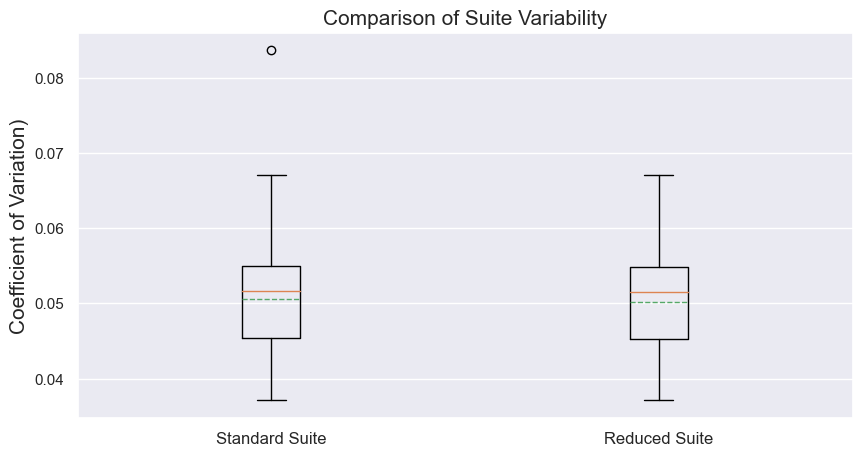

In [260]:
data = [stabilities_old, stabilities_new]

fig, ax = plt.subplots(figsize=(10, 5))
boxplot = ax.boxplot(data, positions=[1, 2], showmeans=True, meanline=True) #, labels=['Standard Suite', 'Reduced Suite'])
ax.set_xticklabels(['Standard Suite', 'Reduced Suite'], fontsize=12)
ax.set_ylabel('Values')
ax.set_title('Comparison of Suite Variability', fontsize=15)
ax.grid(axis='x', alpha=0.00)

plt.ylabel('Coefficient of Variation)', fontsize=15)
plt.savefig('graphics/goquery_variability.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate Performance Changes

In [250]:
# For node coverage
found_changes_nodes = []
found_name_nodes = []
notFound = 0
reduced_idx = [x[0] for x in reduce_graphs_nodes]

for idx, x in enumerate(final_graphs):
    try:
        selected_bench = list(ordered_graphs.keys())[idx]
        name = selected_bench.split('_', 1)[1]
        if idx in reduced_idx:
            found_changes_nodes.append(perf_dict[name])
            found_name_nodes.append(name)
    except KeyError:
        notFound += 1
        failed_benchs_idx.append(idx)
        # print(f"KeyError: {selected_bench} -> {name}")
print(f"KeyErrors: {notFound}")

KeyErrors: 75


In [251]:
# For edge coverage
found_changes_edges = []
found_name_edges = []
notFound = 0
reduced_idx = [x[0] for x in reduce_graphs_edges]

for idx, x in enumerate(final_graphs):
    try:
        selected_bench = list(ordered_graphs.keys())[idx]
        name = selected_bench.split('_', 1)[1]
        if idx in reduced_idx:
            found_changes_edges.append(perf_dict[name])
            found_name_edges.append(name)
    except KeyError:
        notFound += 1
        failed_benchs_idx.append(idx)
        # print(f"KeyError: {selected_bench} -> {name}")
print(f"KeyErrors: {notFound}")

KeyErrors: 75


In [252]:
# Determine not found benchmarks
not_found_nodes = []
not_found_edges = []
for change_b in perf_dict.keys():
    if change_b not in found_name_nodes:
        not_found_nodes.append(change_b)
    if change_b not in found_name_edges:
        not_found_edges.append(change_b)

In [253]:
print(f"Found {len(found_changes_nodes)} changes for node coverage and {len(not_found_nodes)} not found from {len(perf_dict.keys())}")
print(f"Found {len(found_changes_edges)} changes for edge coverage and {len(not_found_edges)} not found from {len(perf_dict.keys())}")

Found 10 changes for node coverage and 0 not found from 10
Found 10 changes for edge coverage and 0 not found from 10


# Time saved

In [51]:
print("Old suite runtime in minutes:", len(final_graphs) * 5 * 3 * 1 / 60)
print("Reduced Suite runtime in minute:", len(reduced_idx) * 5 * 3 * 1 / 60)

Old suite runtime in minutes: 21.5
Reduced Suite runtime in minute: 21.25


# Save Results

In [261]:
# Construct result object
import pickle
results = {}
results['reduced_suite'] = reduced_suite
results['coverage_information'] = coverage_information
results['changes'] = changes
results['perf_dict'] = perf_dict
results['stability_old'] = stabilities_old # Done
results['stabilities_new_nodes'] = stabilities_new_nodes # Done
results['stabilities_new_edges'] = stabilities_new_edges # Done
results['reduce_graphs_nodes'] = reduce_graphs_nodes # Done
results['reduce_graphs_edges'] = reduce_graphs_edges # Done
results['tags'] = tags # Done
results['stability_measures'] = stability_measures # Done
results['found_changes_nodes'] = found_changes_nodes # Done
results['found_changes_edges'] = found_changes_edges # Done
results['newly_found_nodes'] = [] # Done
results['newly_found_edges'] = [] # Done
results['not_found_edges'] = not_found_edges # Done
results['not_found_nodes'] = not_found_nodes # Done
results['missing_nodes'] = [] # Done
results['missing_edges'] = [] # Done

results['reduced_idx'] = reduced_idx
results['failed_benchs_idx'] = failed_benchs_idx
results['unstable_benchmarks_idx'] = unstable_benchmarks_idx

In [263]:
file_path = '../replication-package/goQuery/resultData.pickle'
with open(file_path, 'wb') as file:
    pickle.dump(results, file)